<h1>Floating point numbers</h1>

<h2>Rounding, again</h2>

<p>As not every number is a machine number, numbers are rounded to machine numbers. There are variants of rounding methods. Some are:</p>

<ul><li>round to nearest: find the closest machine number. If a tie round to the even number.</li><li>round to $0$: round down if positive, up if negative</li><li>round to $\infty$ (or $-\infty$): always round up (or down)</li></ul>

<h3>For example,...</h3>

In [ ]:
with_rounding(Float32, RoundUp) do 
       .1 + .2 + .3
end

0.6000000000000001

In [ ]:
with_rounding(Float32, RoundDown) do 
       .1 + .2 + .3
end

0.6

In [ ]:
with_rounding(Float32, RoundDown) do 
    -.1 - .2 - .3
end

-0.6000000000000001

<p>and</p>

In [ ]:
with_rounding(Float32, RoundToZero) do 
       -.1 - .2 - .3
end

-0.6

<h3>A more realistic problem</h3>

In [ ]:
xs = rand(10^7) - 0.5
ys = big(xs)
rup = with_rounding(() -> sum(xs), Float64, RoundUp)
rdown = with_rounding(() -> sum(xs), Float64, RoundDown)
ex = convert(Float64, sum(ys))

ex - sum(xs), ex - rup, ex - rdown

(-8.526512829121202e-13,-7.213998287625145e-10,7.215135156002361e-10)

<h3>How big can the error be in rounding one number?</h3>

<p>We've seen this answered: the significand can be off by at most $1/2$<code>ulp</code> $=1/2 \cdot 2^{-p}$.</p>

<p>At most the <em>error</em> is $1/2 \cdot 2^{-p}\cdot 2^m$.</p>

<p>Write $fl(x)$ to be the machine number that $x$ rounds to. Then</p>

<p>$$ e = |x - fl(x)| \leq 1/2 \cdot 2^{-p}\cdot  2^m $$</p>

<p>The <em>relative error</em> of rounding $x$ is at most</p>

<p>$$ |\frac{x - fl(x)}{x}| = |\frac{e}{x}| = \frac{1/2 \cdot 2^{-p}\cdot 2^m}{q 2^m} \leq 1/2 \cdot 2^{-p} $$</p>

<p>(With just chopping there would be no $1/2$.)</p>

<p>If $\delta$ is the relative error, then we have $fl(x) = x (1 + \delta)$ and $|\delta| \leq 1/2\cdot 2^{-p}$.</p>

<h3>Next closest number</h3>

<p>Suppose $x = 1.a_1a_2 \cdot a_p \cdot 2^m$ is a machine number with precision $p$. What is the relative size of the next largest number? This would be</p>

<p>$$ x' = (1.a_1a_2 \cdot a_p + 2^{-p}) \cdot  2^m $$</p>

<p>The absolute difference being $2^{m-p}$. So if $m$ is larger, the difference is larger – bigger gaps. The <em>relative difference</em> is basically a constant: $2^{-p}2^m/(q 2^m) \leq 2^{-p}$.</p>

<h3>1+</h3>

<p>What is the next number after 1? This would be</p>

<p>$$ 1+ = 1.0000 \cdots 0000 1 \cdot 2^0 $$</p>

<p>The difference $1^+ - 1 = 2^{-52}$ or</p>

In [ ]:
2.0 ^ (-52)

2.220446049250313e-16

<p>As mentioned, this value is given by:</p>

In [ ]:
eps()

2.220446049250313e-16

<p>Or <code>nextfloat(1.0) - 1.0</code></p>

<h2>Error analysis of arithmetic operations</h2>

<p>Rounding can mess with our "inituitive" ideas of how numbers work: Consider the familiar decimal case with $p=3$.</p>

<p>What is $10.1 - 9.93$?</p>

<p>In regular subtraction we align the decimal points</p>

<pre>10.10
09.93
-----
00.17
</pre>

<p>Consider a <em>primitive</em> computer where the digits are shifted to align the decimal points. Hence $9.93$ could become $0.99 \cdot 10^{1}$, if chopped. So that subtraction becomes</p>

<pre>10 *  1.01
      0.99
      ----- 
10 *  0.02
</pre>

<p>The difference between $.20$ and $.17$ is 3 units in the off in the last digit of precision. So rounding can have an adverse effect.</p>

<h3>How far off can subtraction with shifting and truncation be?</h3>

<p>Suppose we have  precision $p$ and binary ($\beta=2$). Then the <em>relative</em> error can be as large as 1 = $\beta-1$!</p>

<p>Consider a small case: $1.00 \cdot 2^0$ and $1.11 \cdot 2^{-1}$. (These are adjacent). Then mathematically the difference is $0.001$, but if $1.11 2^{-1}$ is shifted (and chopped) to $0.11 \cdot 2^0$ to match, then the difference is $0.01$. We have $|(0.001 - 0.01)/(0.001)| =  1$.</p>

<p><strong>Historically</strong> this led to engineering using guard digits (mentioned in the book). The IEEE 754 standard is different – the values should be exactly subtracted then rounded (exact rounding).</p>

<h2>Analysis of floating point operations</h2>

<p>Consider more generally the basic operations of addition, subtraction, multiplication, and division.</p>

<p>Let's assume (contrary to above) that the operations on floating point are correctly done and <em>then</em> rounded to a machine number. (This can be arranged by using more bits for intermediate computations).</p>

<p>If $\odot$ is any of the above operations, what is $fl(x \odot y)$?</p>

<p>We know for $x$ that $fl(x) = x(1 + \delta)$ where $\delta$ is small ($\leq 2^{-p}$) and depends on $x$. So,</p>

<p>$$ fl(x \odot y) = fl(fl(x) \odot fl(y)) = ((x(1+\delta)) \odot (y(1 + \delta)))(1 + \delta) $$</p>

<p>Each $\delta$ is small and possibly different.</p>

<p>Well, how much off are we? Let's quickly check:</p>

In [ ]:
using SymPy

In [ ]:
x,y,d1,d2,d3 = symbols("x,y,d1,d2,d3", real=true)
op = *
( op(x*(1+d1), y*(1+d2)) * (1 + d3) - op(x,y))/op(x,y) |> expand

In [ ]:
op = /
( op(x*(1+d1), y*(1+d2)) * (1 + d3) - op(x,y))/op(x,y) |> expand

<p>But...</p>

In [ ]:
op = +
( op(x*(1+d1), y*(1+d2)) * (1 + d3) - op(x,y))/op(x,y) |> expand

<h2>A Leaky abstraction</h2>

<p>Floating point is a <a href="http://www.johndcook.com/blog/2009/04/06/numbers-are-a-leaky-abstraction/">leaky</a> abstraction for the real numbers. Certain mathematical facts aren't true for floating point operations!</p>

<p>Here are some "gotchas"</p>

<p><li> subtraction of like sized values can be a problem</p>

<p><li> there is no guarantee of <em>associativity</em> ($a+(b+c) = (a+b) + c$.</p>

<p><li> there is no guarantee of <em>commutivity</em> ($a+b = b + a$)</p>

<h3>Subtraction</h3>

<p>Consider again the case of subtracting two numbers that are close by.</p>

<p>We saw</p>

<p>$$ fl(fl(x) - fl(y)) - (x-y) = \frac{1}{x-y}(x (\delta_1 + \delta_3 + \delta_1 \delta_3) + y((\delta_2 + \delta_3 + \delta_2 \delta_3))). $$</p>

<p>If $x$ and $y$ are close, then this can be quite large.</p>

<p>In the book, we have Theorem 1 of section 2.2</p>

<blockquote><p>If $x$ and $y$ are binary floating point numbers with $x > y > 0$ with $$2^{-q} \leq 1 - y/x \leq 2^{-p}$$ Then at most $q$ and <em>at least</em> $p$ significant binary bits are lost in the substraction $x-y$. </p></blockquote>

<h3>Idea</h3>

<p>Suppose we  are in decimal and we have $4$ digits of precision. Consider subtracting $22/7 = 3.142857142857143$ from $\pi = 3.1415926535897...$. We have</p>

<p>$$ fl(\pi) - fl(22/7) = 3.142 - 3.143 = -0.001 = -1.000 \cdot 10^{-3}. $$</p>

<p>The actual answer is $-0.0012644892...$ rounded to  $-1.264\cdot 10^{-3}$. Where did the extra zeros come from in the answer above? They are just added on as there is no obvious alternative when shifted to normalized scientific notation. So we lost 3 digits of accuracy and we have $10^{-3} \leq 1 - \pi/(22/7) \leq 10^{-4}$. </p>

<h3>Proof</h3>

<p>The lower bound:</p>

<p>Say $x = r \cdot 2^n$ and $y=s\cdot 2^m$ with $m \leq n$ and here $1/2 \leq r, s < 1$. Then to "line up the decimal points" we may write $y = s \cdot 2^{m-n} \cdot 2^n$.</p>

<p>$$ x - y = (r - s\cdot 2^{m-n}) \cdot 2^n $$</p>

<p>The significand then satisfies:</p>

<p>$$ r - s \cdot 2^{m-n} = r(1 - \frac{s\cdot 2^m}{r \cdot 2^n}) = r(1 - y/x) < 2^{-p} $$</p>

<p>To put into normalized floating point, the significand must be shifted (there are leading $0$s) and the (at least) $p$ terms added are spurious, so accuracy is lost.</p>

<h3>Example</h3>

<p>Consider $\sin(x) \approx x$. So $\sin(x) - x$ will cause issues.</p>

In [ ]:
x = 1/2^5
X = big(1/2^5)   # more precision
sin(x) - x

-5.086014673919698e-6

In [ ]:
sin(X) - X

-5.086014673921260418878742535535373921881201068959602540274778455791996714357325e-06 with 256 bits of precision

<p>Only accurate to the 10th digit – not the 16th. There is a loss of accuracy</p>

<p>Compare this to addition:</p>

In [ ]:
sin(x) + x

0.062494913985326084

<p>and</p>

In [ ]:
sin(X) + X

6.249491398532607873958112125746446462607811879893104039745972522154420800328564e-02 with 256 bits of precision

<p>The moral of the story – try to avoid subtraction when the values are of the same size.</p>

<p>(Yes, but what about $f(x+h) - f(x)$?)</p>

<h3>floating point is not always associative</h3>

In [ ]:
a,b,c = 10^30, -10^30, 1
a + (b + c),  (a + b) + c # not associative, even with machine numbers

(1,1)

<p>And:</p>

In [ ]:
(0.1 + 0.2) + 0.3,  0.1 + (0.2 + 0.3)

(0.6000000000000001,0.6)

<h3>Floating point is not always commutative</h3>

In [ ]:
0.1 + 0.2 + 0.3, 0.3 +  0.2 +  0.1

(0.6000000000000001,0.6)

<p>Moral: need to be careful when trying to say two things are exactly equal.</p>

<h3>Proof not associative</h3>

<p>Let $a$, $b$ and $c$ be machine numbers. Then we have $fl(a+b) = (a+b)(1+\delta)$, where delta may be $0$, is small, but may not be $0$ and depends on $a$ and $b$. So:</p>

<p>$$ \begin{align} fl((a+b)+c) &= ((a+b)(1+\delta_1)+c)(1+\delta_2) = (a+b)(1+\delta_1)(1+\delta_2) + c(1+\delta_2)\\ fl((a+(b +c) &= (a+ (b+c)(1+\delta_3))(1+\delta_4) =  a(1+\delta_4) + (b+c)(1+\delta_3)(1+\delta_4) \end{align} $$</p>

<p>Are these equal? Add smaller first?</p>

<h3>finessing the problem</h3>

<p>Consider the problem of the quadratic equation and computing $b^2 - 4ac$.</p>

<p>An example of <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.22.6768&rep=rep1&type=pdf">Goldberg</a> of Catastrophic cancellation using rounding to three significant digits illustrates. Suppose $a=1.22$, $b=3.34$ and $c=2.28$.  Then</p>

In [ ]:
a,b,c = 1.22, 3.34, 2.28
b^2 - 4a*c

0.029200000000001225

<p>But if we rounded $b^2$ and $4ac$ to 3 significant digits, we would have</p>

In [ ]:
round(b^2,1) - round(4a*c, 1)  ## b^2 > 10, so round(_,1) is 3 digits, ...

0.09999999999999964

<p>The subtraction isn't the issue here, it is that rounding of floating point numbers to machine numbers can be a source of loss of accuracy.</p>

<h3>Case study: finding the midpoint of two numbers</h3>

<p>In an example in the book (p76) a formula to find the midpoint – the point halfway between $a$ and $b$ – is given:</p>

<p>$$ a + \frac{b-a}{2} $$</p>

<p>And not $(a+b)/2$. Why?</p>

<p>Error in $(a+b)$ can be of size $(a+b)\delta$ which can be large. The error in $b-a$ is generally smaller.</p>

<p>Their general strategem is:</p>

<blockquote><p>in numerical calculations it is best to compute a quantity by adding a small correction term to a previous approximation. </p></blockquote>

<h3>Case study: Polynomial evaluation</h3>

<p>Polynomial evaluation can be sensitive to numeric issues. Problem 3 on page 62 considers a polynomial evaluated 3 ways:</p>

<p>$$ \begin{align} h(x) &= (x-1)^8 \\ f(x) &= x^8 - 8x^7 + 28x^6 - 56x^5 + 70x^4 - 56x^3 + 28x^2 - 8x + 1 \\ g(x) &= (((((((x-8)x + 28)x - 56)x + 70)x -56)x + 28) - 8)x + 1 \end{align} $$</p>

<p>They are interested in values near $1$ (101 values between 0.99 and 1.01 in fact). Let's see the differences</p>

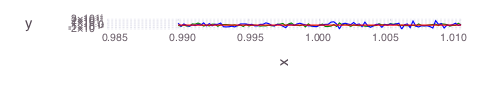

In [ ]:
using Gadfly
h(x) = (x-1.0)^8
f(x) = x^8 - 8x^7 + 28x^6 - 56x^5 + 70x^4 - 56x^3 + 28x^2 - 8x + 1
g(x) = (((((((x-8)*x + 28)*x - 56)*x + 70)*x -56)*x + 28)*x - 8)*x + 1
xs = linspace(0.99, 1.01, 101)
hs = map(h, xs); fs = map(f, xs); gs = map(g, xs)
plot(layer(x=xs, y=hs, Geom.line, Theme(default_color=color("red"))),
layer(x=xs, y=fs, Geom.line, Theme(default_color=color("blue"))),
layer(x=xs, y=gs, Geom.line,Theme(default_color=color("green")))
)

<p>The red one is the most exact, as we would expect. It is basically 8 operations.</p>

<p>The blue has <em>more</em> variability than the green. Why? More operations:</p>

<ul><li>$g$ has only $7$ multiplications -- $f$ has $9 + 8 + 7 + 6 + 5 + \dots + 2$.</li><li>$f$ has large numbers $x^8$ with small numbers $1$ being added. This can cause loss of precision.</li></ul>

<p>Moral $g$ is "better."</p>

<p>The method for $g$ is called "Horner's" method.</p>

<p>You may have seen it in synthetic division:</p>

<h3>Synthetic division</h3>

<p>Evaluate the polynomial $f(x) = x^4 - 4x^3 + 6x^2 - 4x + 3$ at $x=2$. (The answer is $3$):</p>

<pre>2  |  1  -4  6  -4  3
      .   2 -4   4  0 
   ------------------
      1  -2  2   0  3
</pre>

<p>Notice, in the above the numbers are not large in any sense unliek $16 - 32 + 24 -8 + 3$.</p>

<p>The algorithm is on page 21: Writing $p(x) = a_nx^n + \cdots a_2 x^2 + a_1 x + a_0$ we have:</p>

<pre>s = an
for i = n-1 to 0
   s = s*x + a_i
end
</pre>

<p>The order is different, but in <code>Julia</code> there is a "macro" to do this:</p>

In [ ]:
@evalpoly(2, 3, -4, 6, -4, 1)

3

<h3>Kahan summation</h3>

<p>Kahan <a href="https://en.wikipedia.org/wiki/Kahan_summation_algorithm">summation</a> is a means to compensate for the error when sums are made. Here is the basic algorithm:</p>

In [ ]:
function ksum(s, a, c)
  y = a - c
  t = s + y
  c = (t-s) - y
  s = t
  s, c
end

ksum (generic function with 1 method)

<p>It <em>should</em> be that $t-s$ is $y$ and so $c=0$. But if $s$ is large and $y$ small, then there is a loss of precision. The value of $c$ adjusts for this:</p>

<ul><li>$(t-s)$ gets the high bits of $y$, subtracting $y$ from this sets $c$ to the *minus* the low bits of $y$. These are then subtracted off in the next step.</li></ul>

<h3>Testing ...</h3>

In [ ]:
xs = rand(10^7);
S = sum(map(big, xs)) |> x -> convert(Float64, x) ## using 256 bits
ss = 0.0; for i in 1:length(xs) ss = ss + xs[i] end
s = sum(xs)
ks, c = 0.0, 0.0
while(length(xs) > 0)
  ks,c = ksum(ks, shift!(xs), c)
end
S - ks, S-s, S - ss

(0.0,0.0,5.466863512992859e-7)

<h2>Addition of numbers and cumulative error</h2>

<p>Errors accumulate. How big can they get???</p>

<blockquote><p>Theorem 1 (p49) relative error in $\sum_0^n x_i$ is $(1 + \epsilon)^n-1 \approx n\epsilon$. </p></blockquote>

<p>Let $S_{k+1} = x_{k+1} + S_k$ be the partial sum and $T_{k+1} = fl(x_{k+1} + T_k) = (x_{k+1}+ T_k)(1+\delta)$ be the floating point partial sum. What is the relative difference?</p>

<p>$$ \begin{align} \frac{S_{k+1} - T_{k+1}}{S_{k+1}} &= \frac{S_{k+1}(1+\delta) - T_{k+1} - S_{k+1}\delta}{S_{k+1}}\\ &= \frac{(S_k + x_{k+1})(1+\delta) - (T_k + x_{k+1})(1+\delta) - S_{k+1}\delta}{S_{k+1}}\\ &= (1 + \delta)\frac{S_k - T_k}{S_k} \cdot \frac{S_k}{S_{k+1}} - \delta \end{align} $$</p>

<p>Let $\rho_k$ be the absolute value. Since $|\delta| \leq \epsilon$, it follows that with $\rho_0 = 0$:</p>

<p>$$ \rho_{k+1} \leq \rho_k(1+\epsilon) + \epsilon. $$ </p>

<p>This can be solved to yield: $\rho_n \leq (1 + \epsilon)^n - 1$.</p>

<h3>Other bounds</h3>

<p>The maximal possible error for accumulating positive sums grows <em>linearly</em> with the number of sums.</p>

<p>If on average the summands are equally likely to be negative as positive, then a square root of $n$ is the growth.</p>

<p>Better algorithms are possible. Kahan summation is $\mathcal{O}(n\epsilon^2)$, so until $n \approx 1/\epsilon$ the errors are not noticeable. Though this method is a bit slow.</p>

<p>In Julia, <a href="https://en.wikipedia.org/wiki/Pairwise_summation">pairwise</a> summation is used. This has relative error given by $\epsilon \log_2(n)$. For $n=10^7$, this is about $23 \epsilon$, so around $5e-15$.</p>

<h2>Accuracy of functions</h2>

<p>Numbers may be approximate, so after applying a function the error can propagate. How much? Suppose $x$ is the real value and $\bar{x}$ is a machine approximation. Further, assume our function $f$ is perfectly defined and $C^1$. Then [why?]:</p>

<p>$$ f(x) - f(\bar{x}) = f'(\xi)(x - \bar{x}). $$</p>

<p>The relative error divides this difference by $f(x)$ to get:</p>

<p>$$ |\frac{f(x) - f(\bar{x})}{f(x)}| = |x|\frac{f'(\xi)}{f(x)} \cdot \frac{x - \bar{x}}{x} $$</p>

<p>(Written to emphasize a factor times the relative error in the approximation to the number $x$.</p>

<h3>Redundant functions</h3>

<p>In <code>Julia</code> there are many "redundant" functions:</p>

<ul><li>`sinpi` for computing $\sin(\pi x)$, `cospi`, ...</li><li>`expm` to compute $e^x - 1$ for $x$ near 0</li><li>`log1p` to compute $\log(1+x)$ near 0</li></ul>

<p>The reason for <code>expm</code> seems clear. $e^x \approx 1 + x + x^2/2! + \cdot$, so $e^x-1$ for small $x$ is a subtraction of like-sized values.</p>

<p>For <code>log1p</code> <a href="http://www.johndcook.com/blog/2010/06/07/math-library-functions-that-seem-unnecessary/">Cook</a> if $x$ is really small, say $x=10^{-17}$ (<code>x < eps()</code>), then what happens to $1 + x$? In floating point it is 1. But $\log(1+x) \approx x$ by Taylor, so the absolute error is $x$ and the relative error $1$. Quite large. There are more floating point values closer to $0$ than $1$, so smaller values of $x$ can be used in <code>log1p</code>. </p>

<p>In <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.22.6768&rep=rep1&type=pdf">What Every ...</a> there is a theorem that this function</p>

<p>$$ \begin{cases} x & \text{if } 1 \oplus x = 1\\ \frac{x \log(1+x)}{(1+x) - 1}& \text{ otherwise} \end{cases} $$</p>

<p>has relative error less than $5\epsilon$ when $0 \leq x \leq 3/4$ and ... (guard digit, $\log$ computed to within 1/2 ulp).</p>

<p>What about <code>sinpi</code>? It is needed:</p>

In [ ]:
n = 10^8
sin(pi*n), sinpi(n)

(-3.9082928156687315e-8,0)

<p>Why? The definition of sine involves a reduction to the range $[0,2pi]$. Let's just see:</p>

In [ ]:
divrem(pi * 10, 2pi)

(5.0,0.0)

In [ ]:
divrem(pi * 10^8, 2pi)  ## 2e-8 from 2pi

(4.9999999e7,6.283185280343126)

<p>Note though</p>

In [ ]:
divrem(10^8, 2)

(50000000,0)

<h3>Case Study: The Log function</h3>

<p>From <code>openlibm</code></p>

<pre>
/* __ieee754_log(x)
 * Return the logrithm of x
 *
 * Method :                  
 *   1. Argument Reduction: find k and f such that 
 *			x = 2^k * (1+f), 
 *	   where  sqrt(2)/2 < 1+f < sqrt(2) .
 *
 *   2. Approximation of log(1+f).
 *	Let s = f/(2+f) ; based on log(1+f) = log(1+s) - log(1-s)
 *		 = 2s + 2/3 s**3 + 2/5 s**5 + .....,
 *	     	 = 2s + s*R
 *      We use a special Reme algorithm on [0,0.1716] to generate 
 * 	a polynomial of degree 14 to approximate R The maximum error 
 *	of this polynomial approximation is bounded by 2**-58.45. In
 *	other words,
 *		        2      4      6      8      10      12      14
 *	    R(z) ~ Lg1*s +Lg2*s +Lg3*s +Lg4*s +Lg5*s  +Lg6*s  +Lg7*s
 *  	(the values of Lg1 to Lg7 are listed in the program)
 *	and
 *	    |      2          14          |     -58.45
 *	    | Lg1*s +...+Lg7*s    -  R(z) | <= 2 
 *	    |                             |
 *	Note that 2s = f - s*f = f - hfsq + s*hfsq, where hfsq = f*f/2.
 *	In order to guarantee error in log below 1ulp, we compute log
 *	by
 *		log(1+f) = f - s*(f - R)	(if f is not too large)
 *		log(1+f) = f - (hfsq - s*(hfsq+R)).	(better accuracy)
 *	
 *	3. Finally,  log(x) = k*ln2 + log(1+f).  
 *			    = k*ln2_hi+(f-(hfsq-(s*(hfsq+R)+k*ln2_lo)))
 *	   Here ln2 is split into two floating point number: 
 *			ln2_hi + ln2_lo,
 *	   where n*ln2_hi is always exact for |n| < 2000.
 *
 * Special cases:
 *	log(x) is NaN with signal if x < 0 (including -INF) ; 
 *	log(+INF) is +INF; log(0) is -INF with signal;
 *	log(NaN) is that NaN with no signal.
 *
 * Accuracy:
 *	according to an error analysis, the error is always less than
 *	1 ulp (unit in the last place).
 *
 * Constants:
 * The hexadecimal values are the intended ones for the following 
 * constants. The decimal values may be used, provided that the 
 * compiler will convert from decimal to binary accurately enough 
 * to produce the hexadecimal values shown.
 */

#include "openlibm.h"
#include "math_private.h"

static const double
ln2_hi  =  6.93147180369123816490e-01,	/* 3fe62e42 fee00000 */
ln2_lo  =  1.90821492927058770002e-10,	/* 3dea39ef 35793c76 */
two54   =  1.80143985094819840000e+16,  /* 43500000 00000000 */
Lg1 = 6.666666666666735130e-01,  /* 3FE55555 55555593 */
Lg2 = 3.999999999940941908e-01,  /* 3FD99999 9997FA04 */
Lg3 = 2.857142874366239149e-01,  /* 3FD24924 94229359 */
Lg4 = 2.222219843214978396e-01,  /* 3FCC71C5 1D8E78AF */
Lg5 = 1.818357216161805012e-01,  /* 3FC74664 96CB03DE */
Lg6 = 1.531383769920937332e-01,  /* 3FC39A09 D078C69F */
Lg7 = 1.479819860511658591e-01;  /* 3FC2F112 DF3E5244 */

...
</pre>

<h2>2.3 Stable and unstable computations</h2>

<p>The book gives an example of an iterative sequence:</p>

<p>$$ \begin{cases} x_0 = 1, x_1=1/3&\\ x_{n+1} = 13/3 x_n - 4/3 x_{n-1} & (n \geq 1) \end{cases} $$</p>

<p>What happens as $n$ gets larger:</p>

<h3>Using exact fractions</h3>

In [ ]:
xs = [1//1, 1//3]
for i in 1:15
   xn_1, xn = xs[end-1:end]
   push!(xs, 13//3 * xn - 4//3 * xn_1)
end
xs = map(float, xs)   

17-element Array{Float64,1}:
 1.0        
 0.333333   
 0.111111   
 0.037037   
 0.0123457  
 0.00411523 
 0.00137174 
 0.000457247
 0.000152416
 5.08053e-5 
 1.69351e-5 
 5.64503e-6 
 1.88168e-6 
 6.27225e-7 
 2.09075e-7 
 6.96917e-8 
 2.32306e-8 

<p>(Or you could solve $x_2 = 13/9 - 4/3 = 1/9$, $x_3 = 13/27 - 4/9 = 1/27$, ... $x_n=(1/3)^n$.)</p>

<h3>Float32</h3>

<p>Using <code>Float32</code> like the book:</p>

In [ ]:
ys = [1.0, 1/3]
ys = [convert(Float32, y) for y in ys]
for i in 1:15
   yn_1, yn = ys[end-1:end]
   push!(ys, 13//3 * yn - 4//3 * yn_1)
end
[xs ys]

17x2 Array{Any,2}:
 1.0           1.0        
 0.333333      0.333333   
 0.111111      0.111111   
 0.037037      0.0370373  
 0.0123457     0.0123466  
 0.00411523    0.00411871 
 0.00137174    0.00138569 
 0.000457247   0.000513056
 0.000152416   0.000375651
 5.08053e-5    0.000943748
 1.69351e-5    0.00358871 
 5.64503e-6    0.0142927  
 1.88168e-6    0.0571502  
 6.27225e-7    0.228594   
 2.09075e-7    0.914374   
 6.96917e-8    3.65749    
 2.32306e-8   14.63       

<h3>Relative errors are way off:</h3>

In [ ]:
[(x-y)/x for (x,y) in zip(xs, ys)]

17-element Array{Any,1}:
       0.0        
      -2.98023e-8 
      -4.76837e-7 
      -5.84126e-6 
      -7.06166e-5 
      -0.000847619
      -0.0101712  
      -0.122054   
      -1.46465    
     -17.5758     
    -210.909      
   -2530.91       
  -30371.0        
 -364452.0        
      -4.37342e6  
      -5.2481e7   
      -6.29772e8  

<h3>Float64</h3>

<p>Using 64-bit floating point</p>

In [ ]:
zs = [1.0, 1/3]
for i in 1:15
   zn_1, zn = zs[end-1:end]
   push!(zs, 13//3 * zn - 4//3 * zn_1)
end
[xs ys zs]

17x3 Array{Any,2}:
 1.0           1.0           1.0        
 0.333333      0.333333      0.333333   
 0.111111      0.111111      0.111111   
 0.037037      0.0370373     0.037037   
 0.0123457     0.0123466     0.0123457  
 0.00411523    0.00411871    0.00411523 
 0.00137174    0.00138569    0.00137174 
 0.000457247   0.000513056   0.000457247
 0.000152416   0.000375651   0.000152416
 5.08053e-5    0.000943748   5.08053e-5 
 1.69351e-5    0.00358871    1.69351e-5 
 5.64503e-6    0.0142927     5.64498e-6 
 1.88168e-6    0.0571502     1.88147e-6 
 6.27225e-7    0.228594      6.26395e-7 
 2.09075e-7    0.914374      2.05752e-7 
 6.96917e-8    3.65749       5.63989e-8 
 2.32306e-8   14.63         -2.99408e-8 

<h3>What happens?</h3>

<p>Any error in $x_n$ is multiplied by $13/3$. So in particular, any error in $x_1$ is propagated to $x_n$ with a possible error of $(13/3)^n \delta$. So even is $\delta$ is small the possible error is big (and relative error even bigger):</p>

In [ ]:
(13/3)^15 * eps(Float32)

425.24729871286013

<p>The same happens with 64 bits, just slower as the bounds on $\delta$ are smaller.</p>

<p>### What about different starting values?</p>

<p>Had the problem been started differently, say $x_0=1$, $x_1=4$. Then the error in $x_1$ is still propagated, but the relative error stays small, as the sequence grows as $4^n$ and does not decay like $(1/3)^n$:</p>

In [ ]:
ys = [1, 4+eps()]
ys = [convert(Float32, x) for x in xs]
for i in 1:15
   xn_1, xn = xs[end-1:end]
   yn_1, yn = ys[end-1:end]
   push!(xs, 13//3 * xn - 4//3 * xn_1)
   push!(ys, 13/3 * yn - 4//3 * yn_1)
end
xs = [4^(n-1) for n in 1:length(ys)]   
[(x-y)/x for (x,y) in zip(xs, ys)]

32-element Array{Any,1}:
 0.0     
 0.916667
 0.993056
 0.999421
 0.999952
 0.999996
 1.0     
 1.0     
 1.0     
 1.0     
 ⋮       
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     

<p>Yet the "error" is large.</p>

<h3>Case study: different approaches to the same problem lead to different answers...</h3>

<p>Consider the case of computing $I_n = \int_0^1 x^n e^{-x}$. (Attributed to Forsythe, Malcom and Moler 1977). Using integration by parts gives:</p>

<p>$$ I_n = n I_{n-1} - 1/e $$</p>

<p>Or reversing $I_{n-1} = 1/n (I_n + 1/e)$.</p>

<h3>forward solving</h3>

<p>Starting with $I_0 = e - 1$ we can get $I_n$:</p>

In [ ]:
S = e - 1
for n in 1:50
  S = n * S - 1/e
end
S

3.303461008663297e64

<p>All good, right?</p>

<p>Well, ...</p>

In [ ]:
using SymPy
n = 50
x = symbols("x")
integrate(x^n *exp(-x), (x, 0, 1)) |> N

0.007354706795800189

<p>The limit is ...</p>

<p>### What happens</p>

<p>From the expression $n I_{n-1}$, any error is multiplied by $n$. So If $I_1$ is off by $\epsilon$, then $I_2$ is off by $2\epsilon$$, so $I_3$ is off by $3\cdot 2 \epsilon$, ... and $I_50$ is off by $50! \epsilon$. which is <code>3e64</code>.</p>

<p>Working backwards isn't the same issue as we have $1/n \cdot I_n$ so errors are multiplied by $1/n$ not $n$. So we would just need a starting point:</p>

In [ ]:
n = 60
S = integrate(x^n *exp(-x), (x, 0, 1)) |> N
for n in 60:-1:51
  S = 1/n * (S + 1/e)
end
S, integrate(x^50 *exp(-x), (x, 0, 1)) |> N

(0.007354706795800189,0.007354706795800189)

<h2>Conditioning</h2>

<p>Some algorithms perform well under certain inputs and poorly under others. When can you tell?</p>

<blockquote><p>Condition: how sensitive is a solution to small changes in the input? ill-conditioned: small changes can produce large changes. condition number: for some problems a numeric value can be assigned. </p></blockquote>

<h3>Function evaluation</h3>

<p>Suppose our "algorithm" is just $x \rightarrow f(x)$.</p>

<p>What is $f(x+h)$ for small $h$ <em>compared</em> with $f(x)$?</p>

<p>$$ \text{error} = f(x+h) - f(x) = f'(\xi) h, \quad \xi \text{ between $x$ and $x+h$}. $$</p>

<p>The <em>relative error</em> is then</p>

<p>$$ \begin{align} \text{relative error} &= \frac{f(x+h) - f(x)}{f(x)}\\ &= \frac{f'(\xi)h}{f(x)} \approx \frac{xf'(x)}{f(x)} \frac{h}{x}. \end{align} $$</p>

<h3>Example.</h3>

<p>What is the condition number when evaluating $\sqrt(x)$ near $1/2$?</p>

<p>$$ \frac{x f'(x)}{f(x)} = \frac{x \cdot 1/\sqrt{x}}{\sqrt{x}} = 1 $$</p>

<p>So small.</p>

<h3>Evaluation of a root with *uncertainty* in the function</h3>

<p>Think about a polynomial with floating point coefficients – there is rounding.</p>

<p>Let $f(x)$ have a root $r$ and suppose $F(x) = f(x) + \epsilon g(x)$. Then suppose $F$ has a root $r+h$ (nearby, but effected by $\epsilon$. What is $h$? Assume both $f$ and $g$ have Taylor series so that:</p>

<p>$$ 0 = F(r +h) = f(r) + f'(r)h + \mathcal(O)(h^2) + \epsilon \left( g(r) + g'(r)h + \mathcal(O)(h^2) \right) $$</p>

<p>Dropping the big $\mathcal{O}$ term and using $f(r)=0$, gives:</p>

<p>$$ 0 \approx f'(r)h + \epsilon g(r)  + \epsilon g'(r)g $$</p>

<p>Or</p>

<p>$$ h \approx -\epsilon \frac{g(r)}{f'(r) + \epsilon g'(r)} \approx -\epsilon \frac{g(r)}{f'(r)}. $$</p>

<h3>Wilkinson example</h3>

<p>The Wilkinson polynomial is $f(x) = (x-1)(x-2) \cdots (x-20)$. Suppose, the coefficients are perturbed by $10^{-4}x^{20}$. ($\epsilon = 10^{-4}$ and $g(x) = x^{20}$. </p>

<p>We have $g(20) = 20^{20}$. What is $f'(20)$? It is $(20-1)(20-2) \cdots (20-19) = 19!$. (Why?) And so the condition number is</p>

<p>$$ -\epsilon \frac{20^{20}}{19!} $$</p>

<p>With $\epsilon=10^{-4}$ this is:</p>

In [ ]:
1e-4 * 20.0^20 / factorial(19)

86199.60824364352

<p>That is almost $10^5$! So a small perturbation in this problem <em>could</em> lead to dramatically different roots.</p>

In [ ]:
using Roots
p(x) = prod([x-i for i in 1:20])
roots(p) 

20-element Array{Complex{Float64},1}:
     1.0+0.0im     
     2.0+0.0im     
     3.0+0.0im     
     4.0+0.0im     
     5.0+0.0im     
 6.00005+0.0im     
 6.99956+0.0im     
 8.00288+0.0im     
 8.98674+0.0im     
 10.0499+0.0im     
 10.8862+0.0im     
 12.3578+0.0im     
  12.562+0.0im     
 14.5189+0.213088im
 14.5189-0.213088im
 16.2068+0.0im     
 16.8857+0.0im     
 18.0301+0.0im     
 18.9939+0.0im     
 20.0005+0.0im     